In [57]:


import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

warnings.simplefilter(action='ignore', category=FutureWarning)

In [110]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [111]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [112]:
cursor.execute('Select * from "ahshouseholdclass"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

In [113]:
df.columns

Index(['index', 'CONTROL', 'YEAR', 'RATINGHS_BIN', 'BEDROOMS', 'STORIES',
       'PERPOVLVL', 'HHADLTKIDS', 'HINCP', 'UNITSIZE', 'NUMVETS', 'LOTSIZE',
       'UFINROOMS', 'HHAGE', 'PARTNER', 'OTHERAMT', 'KITCHENS', 'NUMSECFAM',
       'OILAMT', 'DINING', 'FINCP', 'NUMELDERS', 'WATERAMT', 'GASAMT',
       'TOTROOMS', 'HHYNGKIDS', 'NUMSUBFAM', 'BATHROOMS', 'NUMYNGKIDS',
       'TRASHAMT', 'NUMOLDKIDS', 'NUMNONREL', 'NUMPEOPLE', 'HHMOVE', 'UTILAMT',
       'ELECAMT', 'NUMADULTS', 'MULTIGEN', 'LAUNDY', 'HHOLDKIDS', 'FINROOMS',
       'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN', 'NUMCARE', 'NUMWALK',
       'HHRACE', 'OMB13CBSA', 'HSHLDTYPE', 'MVG3COST', 'MVG2COST', 'MILHH',
       'HHMAR', 'HHNATVTY', 'COOKFUEL', 'NUMMEMRY', 'NUMERRND', 'NUMSEE',
       'BLD', 'NUMHEAR', 'MVG1COST', 'DIVISION', 'FIREPLACE', 'CONDO',
       'OWNLOT', 'FRIDGE', 'FIRSTHOME', 'HHCARE', 'NOSTEP', 'WASHER', 'HHSEE',
       'KITCHSINK', 'HHERRND', 'WINBARS', 'HHWALK', 'HHHEAR', 'HHSEX',
       'HHMEMRY', 'GA

In [114]:
df['RATINGHS_BIN'].value_counts()

extremely satisfied    7021
satisfied              5284
not satisfied          4887
very satisfied         2916
Name: RATINGHS_BIN, dtype: int64

In [115]:
X = df[['PERPOVLVL', 'BEDROOMS','TOTROOMS','BATHROOMS', 'HHMOVE', 'UTILAMT','HHNATVTY','HINCP','FINCP']]
y = df[['RATINGHS_BIN']]


### Class Imbalanced

In [116]:
# Create the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [ ]:
pd.Series(y_train).value_counts().plot.bar()

In [117]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [118]:
X_sm, y_sm = sm.fit_sample(X_train, y_train.values.ravel())

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


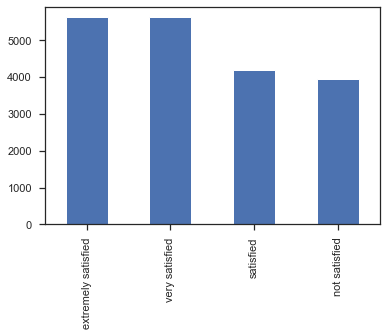

In [119]:
pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


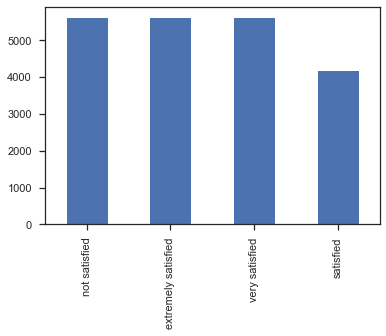

In [120]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


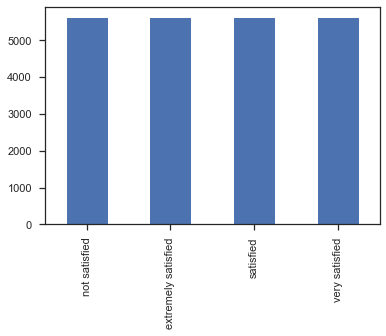

In [121]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

In [80]:
#X = df[['PERPOVLVL', 'BEDROOMS','TOTROOMS','BATHROOMS', 'HHMOVE', 'UTILAMT','HHNATVTY','HINCP','FINCP']]
#y = df[['RATINGHS_BIN']]

In [122]:
def score_model(X, y, estimator, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])


    model.fit(X_train, y_train.values.ravel(), **kwargs)  
    
    expected  = y_train
    predicted = model.predict(X_train)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))

In [125]:
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_sm, y_sm.ravel(), model)

SVC: 0.34986945169712796
NuSVC: 0.4845828670893945
LinearSVC: 0.5518463259977621
SGDClassifier: 0.5124331717021012
KNeighborsClassifier: 0.5316424219818475


/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression: 0.5330722367275892


KeyboardInterrupt: 

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


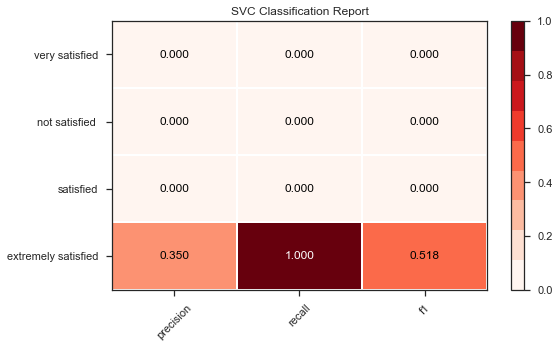

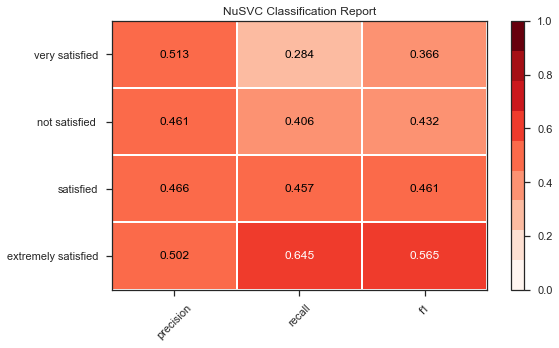

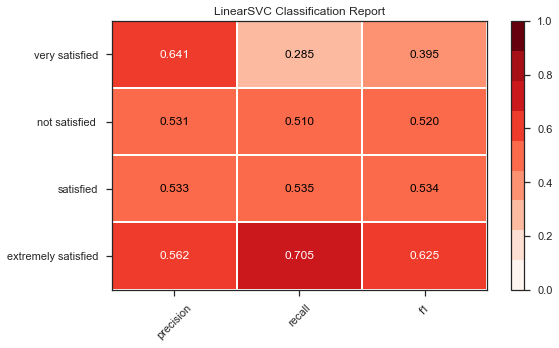

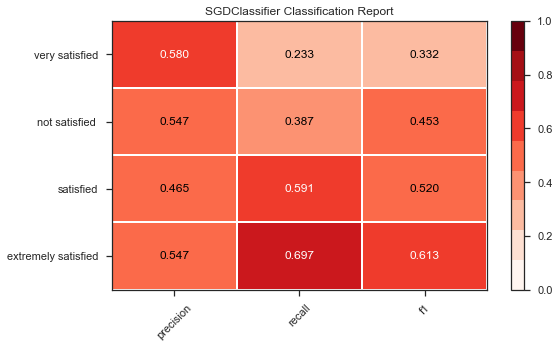

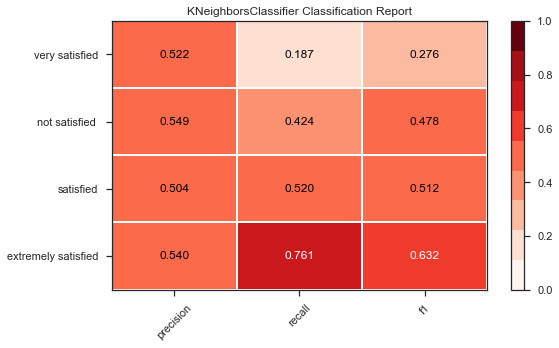

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


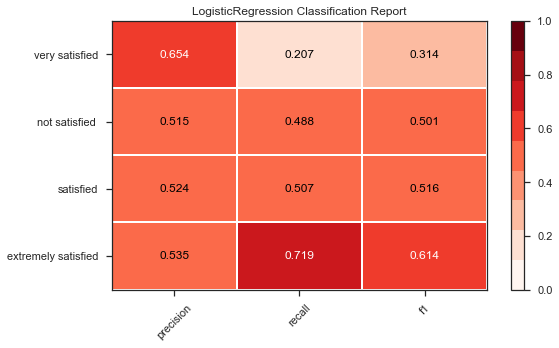

KeyboardInterrupt: 

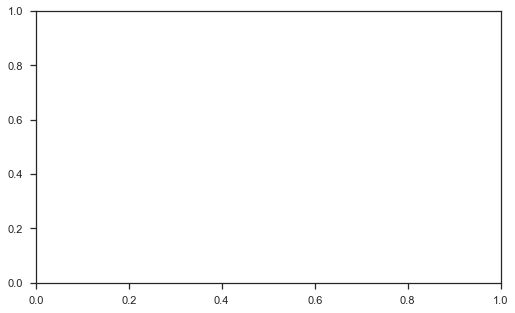

In [126]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['extremely satisfied','satisfied','not satisfied ','very satisfied'], 
        cmap="Reds", size=(600, 360)
    )
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.show()  

for model in models:
    visualize_model(X_sm, y_sm.ravel(), model)

### Confusion Matrixs


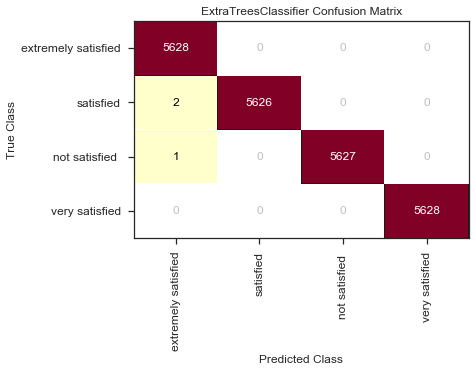

In [129]:
from yellowbrick.classifier import ConfusionMatrix
model = ExtraTreesClassifier(n_estimators=100)

cm = ConfusionMatrix(model, classes=['extremely satisfied','satisfied','not satisfied ','very satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_sm, y_sm.ravel())

cm.score(X_sm, y_sm.ravel())

cm.show()

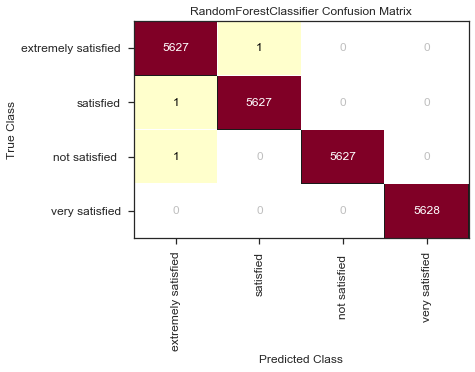

In [128]:
model = RandomForestClassifier(n_estimators=100)

cm = ConfusionMatrix(model, classes=['extremely satisfied','satisfied','not satisfied ','very satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_sm, y_sm.ravel())

cm.score(X_sm, y_sm.ravel())

cm.show()